X shape: torch.Size([64, 1, 32, 32]), y shape: torch.Size([64])


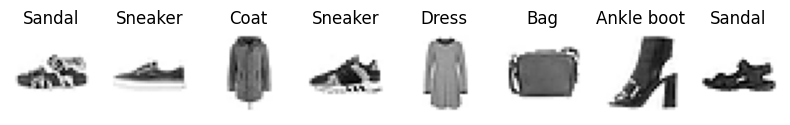

In [56]:
import os
import warnings
warnings.filterwarnings("ignore")
import torch
torch.manual_seed(seed=42)
import torchvision
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Pad(padding=2),
    torchvision.transforms.ToTensor()
])
os.makedirs('data', exist_ok=True)
ds_train = torchvision.datasets.FashionMNIST(root='data', download=True, train=True,
    transform=transform)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, shuffle=True, batch_size=64)

ds_test = torchvision.datasets.FashionMNIST(root='data', download=True, train=False,
    transform=transform)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, shuffle=False, batch_size=16)

idx_to_class = {v: k for k, v in ds_train.class_to_idx.items()}
images, labels = next(iter(dl_train))
print(f"X shape: {images.shape}, y shape: {labels.shape}")
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=[8, 3])
for j in range(len(axes)):
    image = images[j].squeeze()
    label = idx_to_class[labels[j].item()]
    axes[j].imshow(X=image, cmap='binary')
    axes[j].set_title(label=f"{label}")
    axes[j].axis('off')
fig.tight_layout()
fig.show()

In [63]:
import torch
torch.manual_seed(seed=42)

class Sampling(torch.nn.Module):
    """
    This class will be used in the encoder for sampling in the latent space
    """
    def forward(self, z_mean, z_log_var):
        # get the shape of the tensor for the mean and log variance
        batch, dim = z_mean.shape
        # define a normal distribution of epsilon
        epsilon_dist = torch.distributions.normal.Normal(loc=0., scale=1.)
        # generate a normal random tensor (epsilon) with the same shape as z_mean
        epsilon = epsilon_dist.sample(sample_shape=(batch, dim)).to(z_mean.device)
        # apply the reparameterization trick to generate the samples in the latent space
        return z_mean + torch.exp(input=0.5*z_log_var)*epsilon

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                kernel_size=(3, 3), padding=(1, 1), stride=(2, 2)),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Encoder(torch.nn.Module):
    """
    Define the Encoder
    """
    def __init__(self, image_size=(32, 32), embedding_dim=2):
        super().__init__()
        # define the convolutional layers for downsampling and feature extraction
        self.features = torch.nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128)
        )
        # define a flatten layer
        self.flatten = torch.nn.Flatten()
        # define fully connected layers to transform the tensor
        # into the embedding dimensions
        self.fc_mean = torch.nn.Linear(out_features=embedding_dim,
            in_features=128*(image_size[0] // (2**3))*(image_size[1] // (2**3)))
        self.fc_log_var = torch.nn.Linear(out_features=embedding_dim,
            in_features=128*(image_size[0] // (2**3))*(image_size[1] // (2**3)))
        # initialize the sampling layer
        self.sampling = Sampling()
        
    def forward(self, x):
        # apply convolution layers with relu activation function
        x = self.features(x)
        # flatten the tensor
        x = self.flatten(x)
        # get the mean and log variance of the latent space distribution
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        # sample a latent vector using the reparameterization trick
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

class ConvTransposeBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                kernel_size=(3, 3), padding=(1, 1), stride=(2, 2)),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Decoder(torch.nn.Module):
    """
    Define the Decoder
    """

model = Encoder()
x, y = next(iter(dl_train))
print(x.shape)
model(x=x)

torch.Size([64, 1, 32, 32])


(tensor([[-1.6561e-02,  9.3483e-03],
         [-1.1462e-02,  1.4268e-02],
         [-7.9579e-03,  2.2763e-02],
         [-1.2341e-02,  4.6646e-03],
         [-7.0191e-03,  1.0810e-02],
         [-1.1741e-02,  1.0787e-02],
         [-1.2440e-02,  1.4778e-02],
         [-1.5511e-02,  7.9249e-03],
         [-7.9438e-03,  4.4141e-03],
         [-2.1901e-02,  2.0264e-02],
         [-2.0431e-02,  9.7206e-03],
         [-1.3543e-02,  1.6900e-02],
         [-1.4958e-02,  8.6215e-03],
         [-1.3948e-02,  1.3768e-02],
         [-6.9618e-03,  1.0474e-02],
         [-1.6338e-02,  2.3992e-02],
         [-1.4079e-02,  1.0857e-02],
         [-5.0298e-03,  9.7658e-03],
         [-3.1072e-03,  1.2453e-02],
         [-1.3595e-03,  1.5605e-02],
         [-2.2525e-02,  2.5618e-02],
         [-2.2558e-02,  7.5473e-03],
         [-9.2468e-03,  1.6195e-02],
         [-1.8329e-02,  1.9141e-02],
         [-1.9451e-03,  1.2350e-02],
         [-3.1432e-02,  1.4521e-02],
         [-1.4759e-02,  1.2428e-02],
 

In [60]:
image_size = (32, 32)
image_size[1] // (2**3)

4

In [ ]:
import torch
torch.manual_seed(seed=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')